# Outlier detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler

/home/gemsee/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# file_prefix = '/content/drive/MyDrive/DP/analysis/outlier_detection/'

file_prefix = 'tmp_v2/'

## Initialize PyTorch

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
class MyDataset(Dataset):
    """Single PD DF dataset"""

    def __init__(self, df):
        self.df = df.astype('float32')

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self,idx):
        tensor = torch.tensor(self.df.iloc[idx])
        return tensor, torch.tensor(0).float()

In [5]:
# define autoencoder architecture
class AE(nn.Module):
    def __init__(self, original_dim, encoding_dim):
        super(AE, self).__init__()

        mid_dim = (original_dim + encoding_dim) // 2

        self.name = f'ae-with-in-out-{original_dim}-{mid_dim}-{encoding_dim}'

        # input
        self.layer_input = nn.Linear(original_dim, mid_dim)
        # encoder
        self.layer_encoder = nn.Linear(mid_dim, encoding_dim)
        # decoder
        self.layer_decoder = nn.Linear(encoding_dim, mid_dim)
        # output
        self.layer_output = nn.Linear(mid_dim, original_dim)

    def forward(self, x):
        input = F.relu(self.layer_input(x))
        # pass input into encoder
        encoded = F.relu(self.layer_encoder(input))
        # pass encoded into decoder
        decoded = F.relu(self.layer_decoder(encoded))
        # pass to output
        return self.layer_output(decoded)

## Data preparation

In [6]:
def get_datasets_by_vehicle_type(path, no_transform=False):
    df = pd.read_csv(path, index_col=0)
    df['DatKont'] = pd.to_datetime(df['DatKont'])
    df['DatPrvReg'] = pd.to_datetime(df['DatPrvReg'])
    
    def stk_result_to_ordinal(text):
        if text == 'způsobilé':
            return 0
        if text == 'částečně způsobilé':
            return 1
        if text == 'nezpůsobilé':
            return 2
        return 3

    dts_by_category = {
        'MOTOCYKL' : None,
        'NÁKLADNÍ AUTOMOBIL': None,
        'OSOBNÍ AUTOMOBIL': None
    }
    for vehicle_type in dts_by_category.keys():
        df_type = df[df['DrVoz'] == vehicle_type]

        # drop
        # df_type = df_type.drop(['DrTP', 'TZn', 'ObchOznTyp', 'STK', 'VIN', 'DatKont', 'DTKont', 'TypMot', 'DrVoz', 'Ct', 'DatPrvReg', 'Zavady', 'VyslEmise'], axis=1)
        df_type = df_type[['Km', 'StariDnu', 'VyslSTK', 'ZavA', 'ZavB', 'ZavC', 'Zav0', 'Zav1', 'Zav2', 'Zav3', 'Zav4', 'Zav5', 'Zav6', 'Zav7', 'Zav8', 'Zav9']]

        # transform features
        df_type['VyslSTK'] = df_type['VyslSTK'].apply(stk_result_to_ordinal).astype('uint8')

        if no_transform:
            dts_by_category[vehicle_type] = MyDataset(df_type)
        else:
            # standardize
            scaler = StandardScaler()
            df_scaled = scaler.fit_transform(df_type.to_numpy())
            df_scaled = pd.DataFrame(df_scaled, columns=['Km', 'StariDnu', 'VyslSTK', 'ZavA', 'ZavB', 'ZavC', 'Zav0', 'Zav1', 'Zav2', 'Zav3', 'Zav4', 'Zav5', 'Zav6', 'Zav7', 'Zav8', 'Zav9'])

            dts_by_category[vehicle_type] = MyDataset(df_scaled)
    
    return dts_by_category

## Prepare evaluation

In [7]:
def train_and_eval(dataset, name, n_epochs):
    dataloader = torch.utils.data.DataLoader(dataset, 
                                          batch_size = 2048,
                                          shuffle = True)
    
    original_dim = len(dataset.__getitem__(0)[0])
    latent_dim = 6
    model = AE(original_dim, latent_dim).to(device)

    # what are we going to optimize?
    criterion = nn.MSELoss() # if you have a regression task and don't know what to do - use `MSELoss`

    # how are we going to optimize it?
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # if you just don't know what to do - use `Adam` optimizer

    for epoch in range(1, n_epochs + 1):
        # monitor training loss
        train_loss = 0.0

        for data, _ in dataloader: # returns batch shape = (batch_size, 28, 28)
            optimizer.zero_grad() # clear the gradients of all optimized variables
            # print(type(data))
            data = data.to(device) # send to GPU
            outputs = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
            loss = criterion(outputs, data) # calculate the loss
            loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
            optimizer.step() # perform a single optimization step (parameter update)
            train_loss += loss.item()
      
        train_loss_per = train_loss/len(dataloader)
        print(f'    Epoch: {epoch} \tTraining Loss: {train_loss_per:.4f} ({train_loss})')
    
    # save the model
    torch.save(model.state_dict(), f'{file_prefix}{name}.{model.name}.pth')

    # evaluate
    model.eval()

    err_list = []
    for i in range(len(dataset)):
        X = dataset[i][0].to(device)
        with torch.no_grad():
            Y = model(X)                           # Y should be same as X
        errs = X - Y                               # get errors of each feature
        sse_err = torch.sum((errs)*(errs)).item()  # SSE all features
        sse_err = sse_err / original_dim           # sort of norm'ed SSE 
        err_list.append((i, sse_err, errs))        # idx of data item, err

    err_list.sort(key=lambda x: x[1], reverse=True)  # sort by descending error
    
    errs = [tupl[1] for tupl in err_list]
    hist = np.histogram(errs, bins=100)

    return err_list, hist

## Plain evaluation

In [35]:
# run model on all datasets

results = {}

epochs_per_vt = {
    'MOTOCYKL' : 200,
    'NÁKLADNÍ AUTOMOBIL': 100,
    'OSOBNÍ AUTOMOBIL': 70
}

for month in range(1, 2):
    name = f'2019-{str(month).zfill(2)}'

    print(f'-------- {name} --------')

    print('  Loading dataset...')
    path = f'{file_prefix}{name}.csv'
    dts_by_vt = get_datasets_by_vehicle_type(path)

    results[name] = {}

    for vehicle_type, dataset in dts_by_vt.items():
        print(f'  Vehicle type: {vehicle_type}')

        err_list, hist = train_and_eval(dataset, name + '-' + vehicle_type, epochs_per_vt[vehicle_type])

        results[name][vehicle_type] = {
            'dataset': dataset,
            'err_list': err_list,
            'hist': hist
        }

-------- 2019-01 --------
  Loading dataset...
  Vehicle type: MOTOCYKL
    Epoch: 1 	Training Loss: 0.9627 (1.9253066778182983)
    Epoch: 2 	Training Loss: 0.9573 (1.914690375328064)
    Epoch: 3 	Training Loss: 0.9559 (1.9117481708526611)
    Epoch: 4 	Training Loss: 0.9543 (1.9085670113563538)
    Epoch: 5 	Training Loss: 0.9496 (1.8992187976837158)
    Epoch: 6 	Training Loss: 0.9503 (1.9006927013397217)
    Epoch: 7 	Training Loss: 0.9477 (1.8953468799591064)
    Epoch: 8 	Training Loss: 0.9455 (1.890961766242981)
    Epoch: 9 	Training Loss: 0.9424 (1.8848159313201904)
    Epoch: 10 	Training Loss: 0.9375 (1.8749220967292786)
    Epoch: 11 	Training Loss: 0.9377 (1.87534499168396)
    Epoch: 12 	Training Loss: 0.9320 (1.8640095591545105)
    Epoch: 13 	Training Loss: 0.9306 (1.8611567616462708)
    Epoch: 14 	Training Loss: 0.9262 (1.852416753768921)
    Epoch: 15 	Training Loss: 0.9245 (1.8490101099014282)
    Epoch: 16 	Training Loss: 0.9213 (1.842684805393219)
    Epoch: 17 	

In [36]:
# save the results
import pickle
with open(f'{file_prefix}results.pickle', 'wb') as file:
    pickle.dump(results, file, protocol=pickle.HIGHEST_PROTOCOL)

### Results evaluation
As we can see from the histogram below, the data points have been divided to a majority class with only a fraction of outliers.
The autoencoder is thus working.

In [13]:
for name, vts in results.items():
    print(name)
    for vt, data in vts.items():
        print('  ' + vt)
        print('    ' + str(data['hist'][0]))

2019-01
  MOTOCYKL
    [3733  107   53   19   12   20   14   12    6   19    5    4    1    2
    2    1    0    1    2    0    0    1    1    1    2    0    0    2
    0    0    0    2    0    1    0    0    0    0    0    0    0    0
    1    0    0    0    0    0    0    0    0    0    0    0    0    0
    1    0    0    0    0    0    0    0    0    0    0    0    0    1
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    2    0    0    0    0    0    0    0    0    0
    0    1]
  NÁKLADNÍ AUTOMOBIL
    [32372  3621  1678   782   270   151    97    50    44    58    46    28
    23    10     5     5     2     3     5     7     8     4     3     1
     0     2     1     0     0     0     1   127     0     3     1     0
     1     0     1     1     1     0     0     0     0     0     0     0
     0     2     1     1     1     0     1     0     0     1     0     0
     3     6     4     1     2     0     1     1     0     0     1     0
     

2019-01


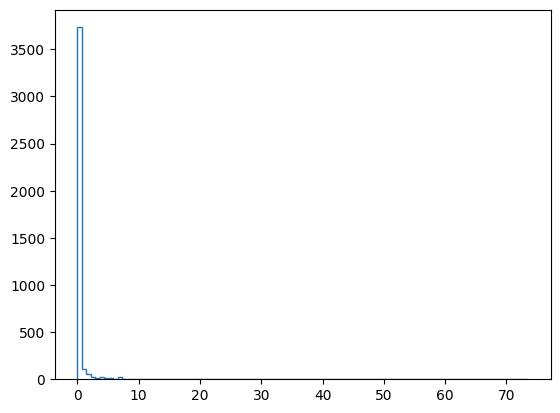

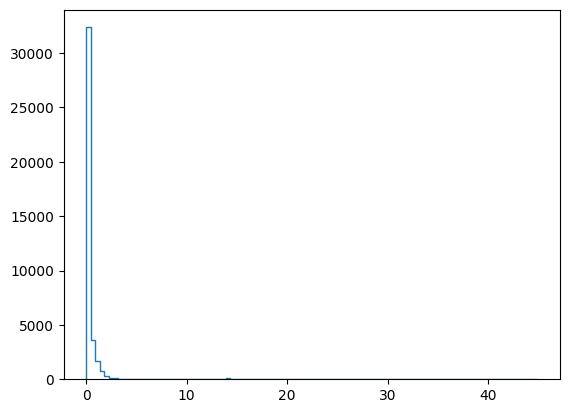

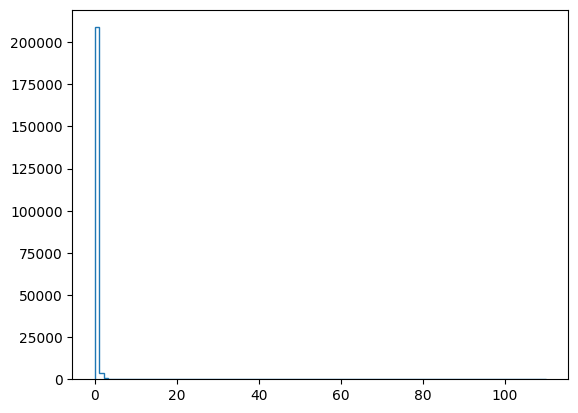

In [20]:
for name, vts in results.items():
    print(name)
    for vt, data in vts.items():
        plt.stairs(data['hist'][0],data['hist'][1])
        plt.show()

In [43]:
# display the items with the largest error
for name, vts in results.items():
    print(name)
    orig_df = get_datasets_by_vehicle_type(f'{file_prefix}{name}.csv', no_transform=True)
    for vt, data in vts.items():
        print('  ' + vt)
        n = 100
        err_items_indices = data['err_list'][-n:]
        err_items_df = orig_df[vt].df.iloc[[tupl[0] for tupl in err_items_indices]]
        display(err_items_df.head(n))

2019-01
  MOTOCYKL


,Km,StariDnu,VyslSTK,ZavA,ZavB,ZavC,Zav0,Zav1,Zav2,Zav3,Zav4,Zav5,Zav6,Zav7,Zav8,Zav9
2906,24485.0,7107.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63561,33355.0,8324.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63371,33153.0,7414.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251154,32800.0,8672.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251223,23193.0,7733.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64132,27944.0,8308.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
151197,27568.0,7923.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251432,28738.0,7959.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14653,28479.0,7932.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  NÁKLADNÍ AUTOMOBIL


,Km,StariDnu,VyslSTK,ZavA,ZavB,ZavC,Zav0,Zav1,Zav2,Zav3,Zav4,Zav5,Zav6,Zav7,Zav8,Zav9
75064,249850.0,4369.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246572,232203.0,5053.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203844,221663.0,4416.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121746,215485.0,4628.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242287,254877.0,4508.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21522,238153.0,4639.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
237777,234708.0,4622.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32314,234757.0,4716.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32315,234757.0,4716.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  OSOBNÍ AUTOMOBIL


,Km,StariDnu,VyslSTK,ZavA,ZavB,ZavC,Zav0,Zav1,Zav2,Zav3,Zav4,Zav5,Zav6,Zav7,Zav8,Zav9
220109,144571.0,5411.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98903,147510.0,5875.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
159751,142135.0,5539.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
133453,141808.0,5504.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187779,145537.0,5797.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220863,145408.0,5655.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118936,144264.0,5600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174334,143406.0,5494.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38875,145004.0,5622.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The outliers are mostly vehicles with little to none issues found. It has been concluded that this is not a desired outcome, but since we do not yet have more features such as engine properties, we can't expect any more interesting results.

## DeepExplainer
We will now try to explain the reconstruction error using SHAP DeepExplainer. This can allow us to see the reasoning inside the network.

The data are loaded from disk as this has been designed to be run anytime after training, using previously saved data.

In [44]:
%pip install shap
import shap
import copy

In [8]:
# load the results
import pickle
results = None
with open(f'{file_prefix}results.pickle', 'rb') as file:
    results = pickle.load(file)

### Explaining a single data point

In [46]:
from sklearn.preprocessing import StandardScaler

# load results
name = '2019-01'
vt = 'NÁKLADNÍ AUTOMOBIL'
data = results[name][vt]

# init model
original_dim = len(data['dataset'].__getitem__(0)[0])
latent_dim = 6
model = AE(original_dim, latent_dim).to(device)
path = f'{file_prefix}{name}-{vt}.{model.name}.pth'
model.load_state_dict(torch.load(path))
model.eval()

# create a part of the original dataset to be used for explaining
df = copy.deepcopy(data['dataset'].df)
# rescale to obtain better shap values
df = StandardScaler().fit_transform(df.to_numpy())
df = pd.DataFrame(df, columns=data['dataset'].df.columns)
# get a training sample for shap
df_red = df.sample(n=10000, random_state=468151)

# create the explainer
sample = torch.tensor(df_red.values).to(device)
print(sample.shape)
dex = shap.DeepExplainer(model, sample)

torch.Size([10000, 16])


In [47]:
df.head()

,Km,StariDnu,VyslSTK,ZavA,ZavB,ZavC,Zav0,Zav1,Zav2,Zav3,Zav4,Zav5,Zav6,Zav7,Zav8,Zav9
0,-1.186263,-0.564706,-0.309684,0.258274,-0.237461,-0.104646,-0.30847,0.484393,-0.340856,-0.323563,-0.524757,1.963638,-0.087433,-0.177761,-0.106762,-0.024155
1,-1.270586,-0.440912,-0.309684,-0.872497,-0.237461,-0.104646,-0.30847,-0.615417,-0.340856,-0.323563,-0.524757,-0.672435,-0.768574,-0.177761,-0.106762,-0.024155
2,-0.314834,0.793608,-0.309684,1.765970,-0.237461,-0.104646,2.61910,1.584202,-0.340856,-0.323563,0.693130,0.645602,1.955990,-0.177761,-0.106762,-0.024155
3,-1.071728,0.626384,-0.309684,-0.872497,-0.237461,-0.104646,-0.30847,-0.615417,-0.340856,-0.323563,-0.524757,-0.672435,-0.768574,-0.177761,-0.106762,-0.024155
4,-0.884299,0.810194,-0.309684,0.258274,-0.237461,-0.104646,-0.30847,0.484393,-0.340856,-0.323563,0.693130,-0.672435,-0.087433,-0.177761,-0.106762,-0.024155


(11172,
 2.9727635383605957,
 tensor([-2.1664,  0.6247, -0.1879, -0.1208,  1.9829, -0.6431, -2.3456, -2.2728,
         -0.8076,  2.6981, -0.8403,  3.0594,  1.5911, -2.3658,  0.0190,  1.1364],
        device='cuda:0'))

,Km,StariDnu,VyslSTK,ZavA,ZavB,ZavC,Zav0,Zav1,Zav2,Zav3,Zav4,Zav5,Zav6,Zav7,Zav8,Zav9
11172,-0.889263,0.560383,2.800009,1.76597,5.349829,-0.104646,-0.30847,-0.615417,-0.340856,5.079607,1.911018,4.599711,3.318271,-0.177761,-0.106762,-0.024155


,Km,StariDnu,VyslSTK,ZavA,ZavB,ZavC,Zav0,Zav1,Zav2,Zav3,Zav4,Zav5,Zav6,Zav7,Zav8,Zav9
66105,84651.0,9141.0,1.0,7.0,6.0,0.0,0.0,0.0,0.0,2.0,2.0,4.0,6.0,0.0,0.0,0.0


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([ 0.00000000e+00, -3.20475660e-02, -3.71766627e-01,  1.43385872e-01,
        6.54752925e-02,  1.05336383e-02, -3.84096941e-03,  1.40867522e-03,
        3.05368900e-02,  1.97783732e+00,  1.02829531e-01, -3.46989155e-01,
        2.34502658e-01, -1.23967314e-02, -4.39547328e-03, -1.10937154e-03])

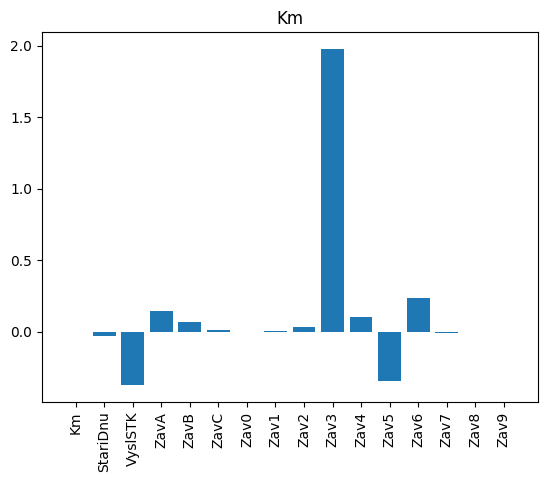

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([ 0.05134889,  0.        , -0.04439617,  0.09949845, -0.24475101,
        0.00337958, -0.03855365, -0.02896939, -0.00293291, -0.52188772,
       -0.01214895,  0.26261622,  0.17252073,  0.0012718 , -0.00397379,
       -0.00389338])

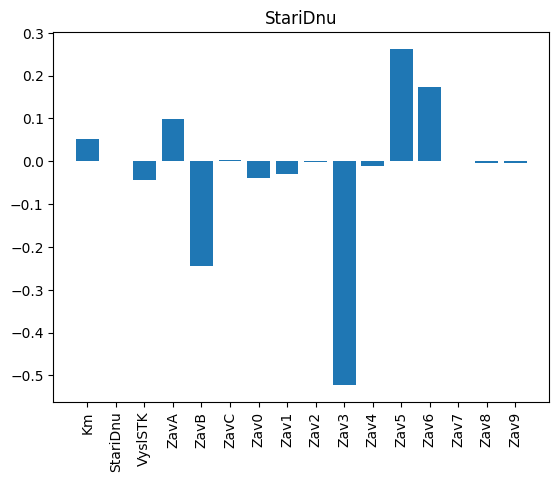

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([ 9.80845168e-02, -3.62701938e-02,  0.00000000e+00, -1.67151898e-01,
        1.75079179e+00, -2.10853200e-02, -4.78202105e-02,  2.83092959e-03,
        8.61289632e-03,  2.05181271e-01,  2.54341602e-01,  6.77347556e-02,
       -1.61965862e-01, -1.95528269e-02,  3.44659093e-05,  5.83142333e-04])

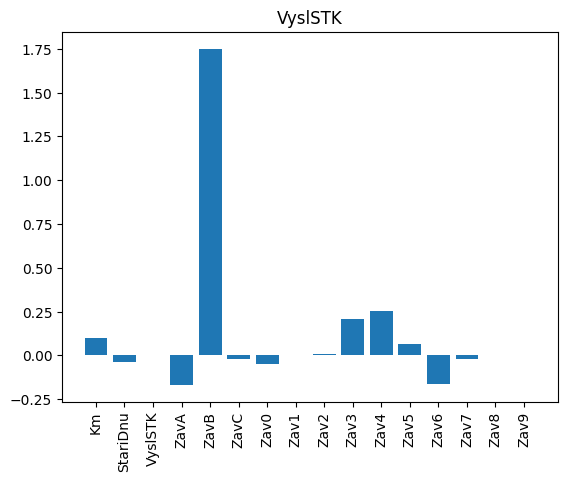

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([-0.07790273,  0.05250177, -0.2218906 ,  0.        , -0.3096205 ,
        0.00630269, -0.00489621, -0.12738402, -0.0439336 ,  0.12620862,
        0.21823278,  0.91470146,  0.91968673, -0.00618737, -0.00455942,
       -0.0011147 ])

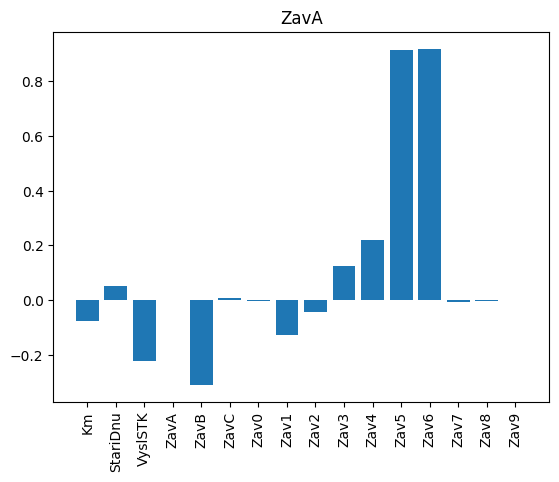

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([ 0.03540751, -0.04163165,  0.94159085, -0.10812085,  0.        ,
       -0.01167013, -0.04309757, -0.00432996, -0.00657997,  0.55607402,
        0.28366745,  0.06919499, -0.0860724 , -0.02176761, -0.00646799,
        0.00160163])

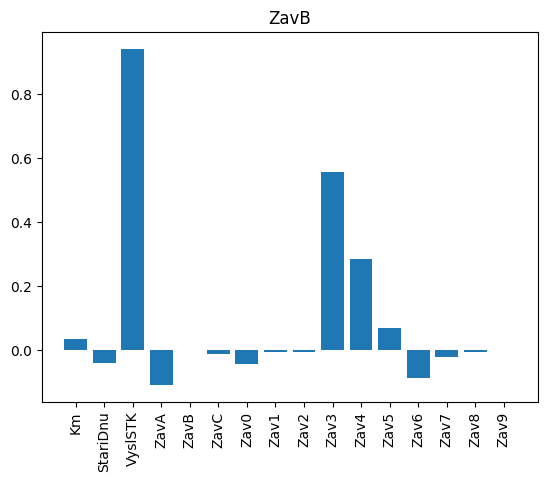

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([ 0.03410691, -0.03693796,  0.22319873, -0.04838711,  0.41249946,
        0.        ,  0.00629444,  0.00623173, -0.06448004,  0.22242415,
        0.06030912, -0.03876344, -0.11488605, -0.00171405,  0.00302163,
       -0.00588127])

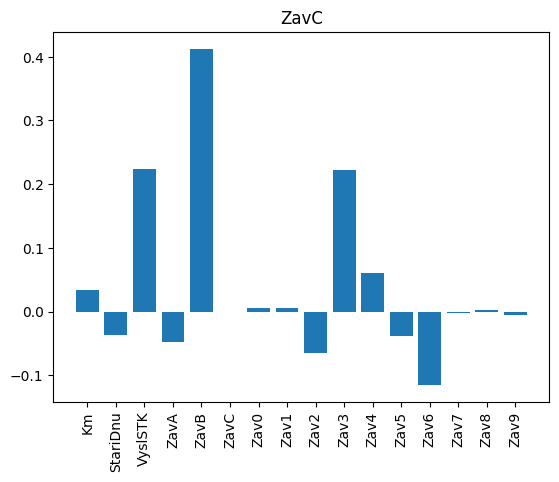

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([ 0.06403787,  0.04789581,  0.52269047,  0.05919545,  0.80449146,
        0.02112841,  0.        , -0.04379369,  0.05296336, -0.49878839,
        0.16953588,  0.38702399,  0.23945679, -0.01381418,  0.00419887,
       -0.00354823])

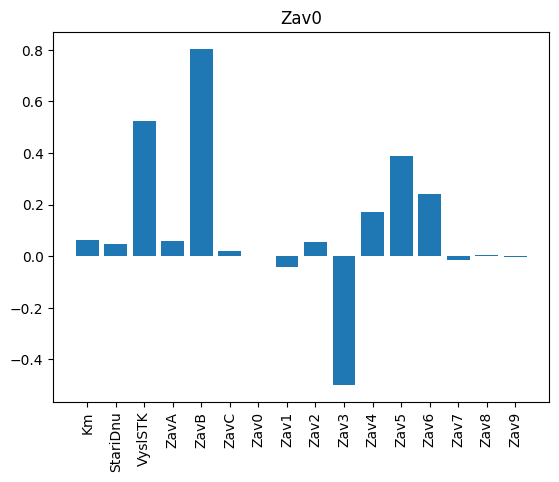

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([-7.05324160e-03,  4.50363904e-02, -5.42389695e-03,  3.81081492e-01,
        1.77147600e-03, -1.16750496e-02,  3.52783967e-03,  0.00000000e+00,
       -1.30632892e-02, -1.01999141e-01,  1.88340276e-01,  7.32541919e-01,
        6.55728579e-01, -5.96494041e-03, -3.50393634e-03, -5.88135270e-04])

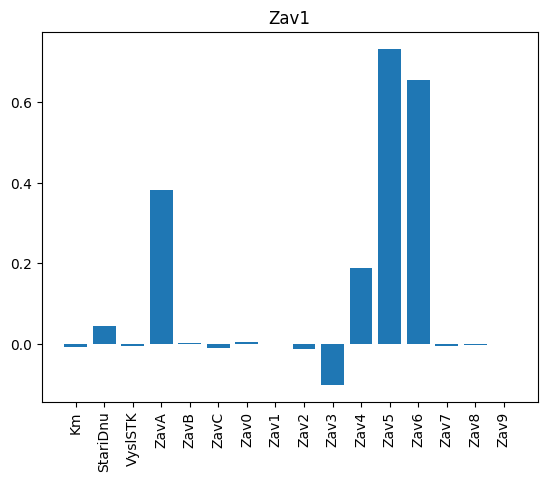

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([ 8.77539888e-02, -5.25638908e-02, -7.35379010e-02,  2.18713403e-01,
       -1.69385254e-01, -1.67634971e-02,  3.30283567e-02, -3.60287055e-02,
        0.00000000e+00,  4.51021254e-01,  6.58905283e-02,  2.76433408e-01,
        4.93050776e-02,  7.21694110e-03,  4.26022947e-04, -4.91961371e-04])

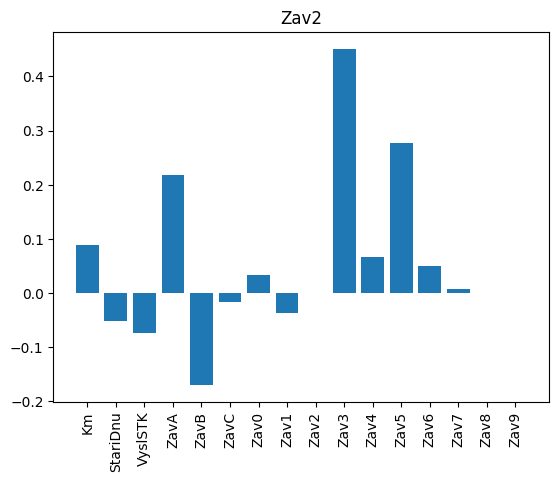

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([-3.48674476e-01, -7.63318464e-02,  4.25213277e-02,  3.75219174e-02,
        7.36178219e-01,  8.01618584e-03, -1.38863679e-02,  1.59945507e-02,
       -5.08226305e-02,  0.00000000e+00,  1.70999408e-01, -4.42092419e-01,
        1.03013217e-02, -1.78793129e-02,  6.96025696e-03,  1.78641312e-05])

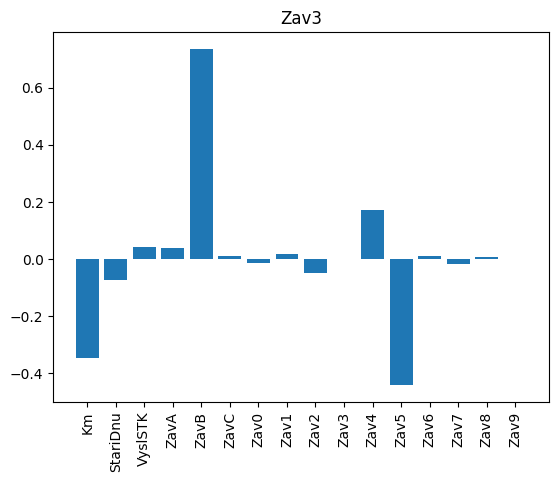

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([-3.66936997e-02,  4.18810159e-05,  3.97935033e-01,  1.81002587e-01,
        8.28119159e-01,  1.92349660e-03, -2.75521725e-02, -5.92377558e-02,
       -1.54548418e-02,  4.47273135e-01,  0.00000000e+00,  4.14988577e-01,
        3.63988727e-01, -1.54015468e-02,  3.77923460e-03,  7.91623490e-04])

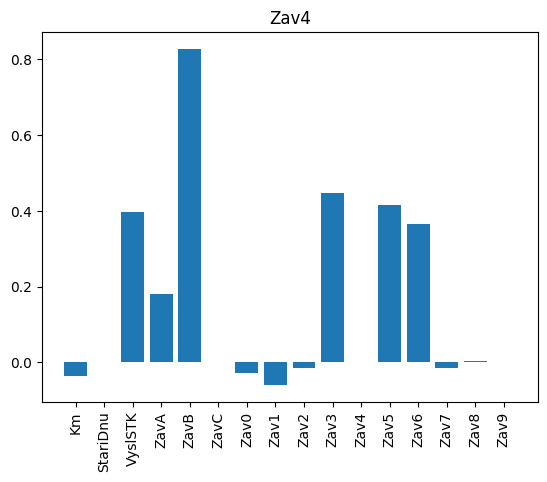

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([ 7.61119574e-02,  5.13341427e-02,  1.07897609e-01,  3.38584900e-01,
        5.91991134e-02, -5.30634634e-03,  6.86988176e-04, -9.65172723e-02,
       -1.08613530e-02, -5.07261276e-01,  1.79069668e-01,  0.00000000e+00,
        6.06474638e-01, -4.48333146e-03, -3.76554462e-03,  5.42837428e-04])

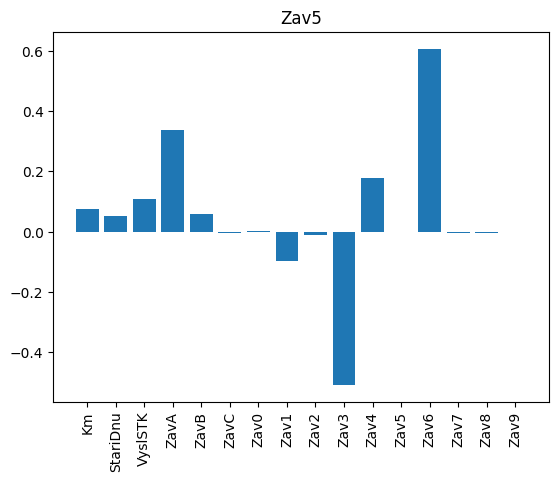

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([-0.05562655,  0.06412086, -0.1323663 ,  0.47894469, -0.17993207,
        0.00136057, -0.00947104, -0.11514402,  0.01358046, -0.07295775,
        0.20042501,  0.83810192,  0.        , -0.00721475, -0.0058476 ,
       -0.00090375])

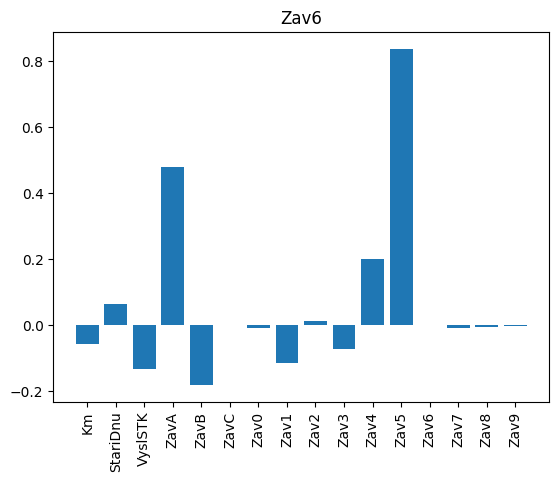

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([-7.56851435e-02, -7.97172263e-03,  3.38061363e-01,  5.79803176e-02,
        7.76234269e-01, -1.05314062e-03, -2.46512629e-02, -2.50831470e-02,
        2.41835117e-02,  5.56539237e-01,  1.82315126e-01,  1.25722766e-01,
        1.69607952e-01,  0.00000000e+00,  2.63030129e-03,  6.89991517e-04])

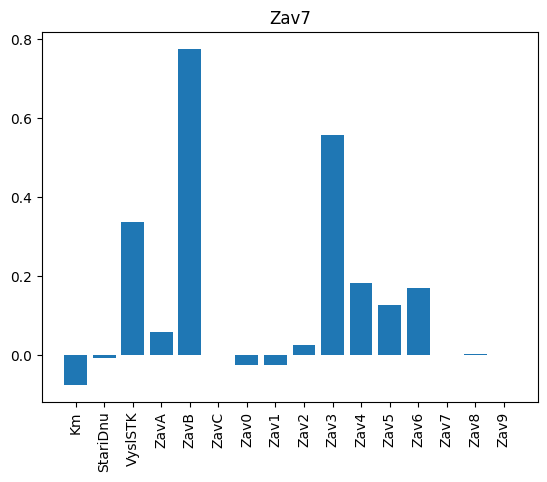

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([-7.42126163e-03,  2.48467037e-03, -2.88428366e-02,  7.62988674e-03,
       -3.01561039e-02, -3.31722223e-03,  4.73117689e-03, -1.73317618e-03,
        8.41453671e-03,  1.66750047e-04, -9.71945934e-04,  4.93879570e-03,
        1.73560400e-02,  1.32480593e-04,  0.00000000e+00, -4.81842326e-05])

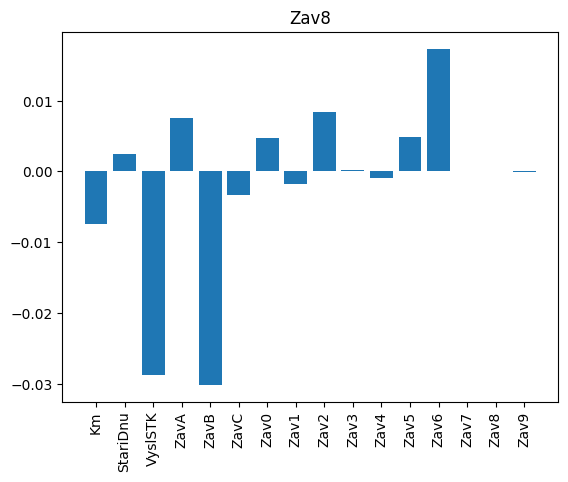

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([-0.05943704,  0.03268631, -0.32789442,  0.07056066, -0.52581078,
       -0.02339802, -0.08424566, -0.00153688,  0.02388309, -0.27885821,
       -0.0662939 ,  0.01700987,  0.14968976,  0.00435652, -0.00775886,
        0.        ])

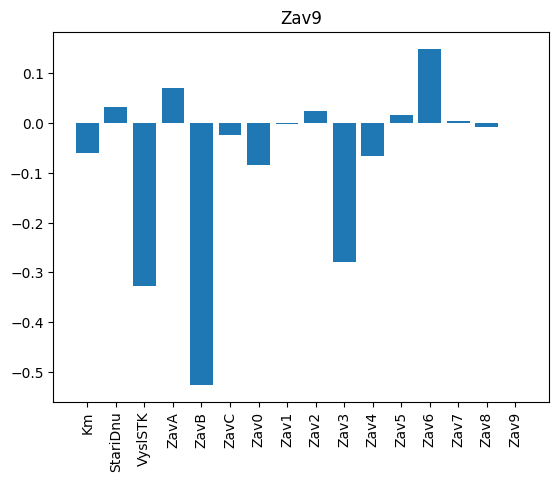

In [50]:
# try explaining a single data point

# pick a data point
dt_index = 500
err_item_props = data['err_list'][dt_index]
err_item = data['dataset'].df.iloc[[err_item_props[0]]]

orig_df = get_datasets_by_vehicle_type(f'{file_prefix}{name}.csv', no_transform=True)[vt].df
orig_err_item = orig_df.iloc[[err_item_props[0]]]

display(err_item_props)
display(err_item)
display(orig_err_item)
# display(torch.tensor(err_item.values))

# get a backup of model parameters
original_params = copy.deepcopy(model.state_dict())

shap_values = []

# explain each feature (only explaing features with a big error later)
for feature_index in range(0, len(err_item.columns)):
    # print(f'{feature_index}: {err_item_props[2][feature_index]}')

    # zero out the "feature_index"th parameter in each neuron
    # of the first layer
    modified_params = copy.deepcopy(model.state_dict())
    for neuron in modified_params['layer_input.weight']:
        neuron[feature_index] = 0
    model.load_state_dict(modified_params)

    # explain
    dex = shap.DeepExplainer(model, sample)
    # shap_values.append(dex.shap_values(torch.tensor(err_item.values).to(device)))
    shap_value = dex.shap_values(torch.tensor(err_item.values).to(device))

    # restore params
    model.load_state_dict(original_params)

    # plot shap_values
    shap_value = shap_value[feature_index][0]
    display(shap_value)
    # display(err_item.values[0][0])

    plt.bar(err_item.columns, height=shap_value)
    plt.title(err_item.columns[feature_index])
    plt.xticks(rotation=90)  
    plt.show()

An explanation of one of the points with a reasonable error has been left here. As we can see, the DeepExplainer shows many complex relationships.